1. Consider the boundary value problem:
$$
-u'' = e^{sin(x)},\  \ u(0) = 0,\  \ u(1) = 0
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
def thomas_tridiag(a, d, c, b):
    a = np.array(a, dtype=float).copy()
    d = np.array(d, dtype=float).copy()
    c = np.array(c, dtype=float).copy()
    b = np.array(b, dtype=float).copy()
    n = d.size
    for i in range(1, n):
        w = a[i-1] / d[i-1]
        d[i] -= w * c[i-1]
        b[i] -= w * b[i-1]
    x = np.empty(n)
    x[-1] = b[-1] / d[-1]
    for i in range(n-2, -1, -1):
        x[i] = (b[i] - c[i] * x[i+1]) / d[i]
    return x

def solve_poisson(n):
    h = 1.0 / n
    x = np.linspace(0.0, 1.0, n + 1)
    f = np.exp(np.sin(x[1:-1]))
    a = -np.ones(n-2) / h**2
    d =  2.0*np.ones(n-1) / h**2
    c = -np.ones(n-2) / h**2
    u_int = thomas_tridiag(a, d, c, f)
    u = np.zeros(n+1)
    u[1:-1] = u_int
    return x, u

def energy_seminorm(u, h):
    return (1.0/h)*float(np.sum(np.diff(u)**2))

def residual_inf(u, n):
    h = 1.0/n
    x = np.linspace(0.0, 1.0, n+1)
    f = np.exp(np.sin(x[1:-1]))
    u_int = u[1:-1]
    Au = (2*u_int - u[2:] - u[:-2]) / h**2
    r = f - Au
    return float(np.max(np.abs(r)))

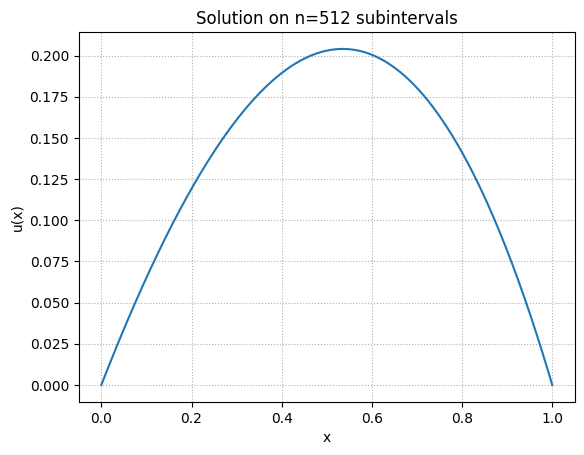

In [3]:
n = 512
x, u = solve_poisson(n)

plt.figure()
plt.plot(x, u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Solution on n={n} subintervals")
plt.grid(True, which='both', ls=':')
plt.show()

,n (fine),h (fine),||u_h - u_{2h}||_inf,p_obs from prev,residual_inf (fine),energy (fine)
0,64,0.015625,3.231188e-06,NaN,2.426948e-13,0.222800
1,128,0.007812,8.074116e-07,2.000688,1.237233e-12,0.222844
2,256,0.003906,2.018288e-07,2.000172,3.856915e-12,0.222855
3,512,0.001953,5.045571e-08,2.000043,1.774980e-11,0.222858
4,1024,0.000977,1.261387e-08,2.000007,7.522560e-11,0.222858
5,2048,0.000488,3.153609e-09,1.999935,3.043612e-10,0.222859
6,4096,0.000244,7.890233e-10,1.998864,1.275565e-09,0.222859
7,8192,0.000122,1.975145e-10,1.998110,5.689189e-09,0.222859
8,16384,0.000061,5.221854e-11,1.919325,2.191271e-08,0.222859
9,32768,0.000031,2.707326e-11,0.947693,8.436855e-08,0.222859


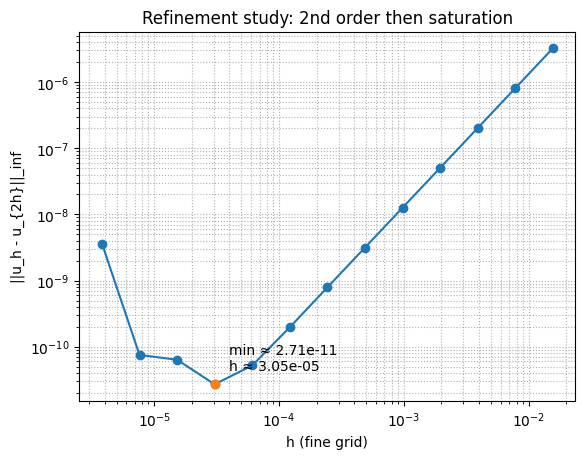

Last observed order p ≈ -5.591
Minimum inter-grid error ≈ 2.707e-11 at h ≈ 3.052e-05
||u||_inf (n=512) ≈ 0.204021, bound (1/8)||f||_inf ≈ 0.289972


In [6]:
levels = 14
N0 = 32
sols = []
for k in range(levels):
    n_k = N0*(2**k)
    xk, uk = solve_poisson(n_k)
    sols.append((n_k, xk, uk))

rows = []
errs = []
hs = []
for k in range(1, levels):
    n_c, x_c, u_c = sols[k-1]
    n_f, x_f, u_f = sols[k]
    h_f = 1.0 / n_f
    err = float(np.max(np.abs(u_f[::2] - u_c)))
    errs.append(err)
    hs.append(h_f)
    p_obs = None
    if k >= 2 and errs[-2] > 0 and err > 0:
        p_obs = math.log(errs[-2]/err, 2.0)
    res = residual_inf(u_f, n_f)
    en  = energy_seminorm(u_f, h_f)
    rows.append({"n (fine)": n_f, "h (fine)": h_f, "||u_h - u_{2h}||_inf": err,
                 "p_obs from prev": p_obs, "residual_inf (fine)": res, "energy (fine)": en})

df = pd.DataFrame(rows)
display(df)

imin = int(np.argmin(errs))
plt.figure()
plt.loglog(hs, errs, marker='o')
plt.loglog(hs[imin], errs[imin], 'o')     # 標記最小點
plt.annotate(f"min ≈ {errs[imin]:.2e}\nh ≈ {hs[imin]:.2e}",
             (hs[imin], errs[imin]), textcoords="offset points", xytext=(10,10))
plt.xlabel("h (fine grid)")
plt.ylabel("||u_h - u_{2h}||_inf")
plt.title("Refinement study: 2nd order then saturation")
plt.grid(True, which='both', ls=':')
plt.show()

if len(errs) >= 2 and errs[-1] > 0 and errs[-2] > 0:
    p_last = math.log(errs[-2]/errs[-1], 2.0)
else:
    p_last = None
min_err = float(np.min(errs)) if len(errs) else float("nan")
h_at_min = hs[int(np.argmin(errs))] if len(errs) else float("nan")
u_inf = float(np.max(np.abs(u)))
f_inf = float(np.max(np.exp(np.sin(x))))
bound = 0.125 * f_inf

print(f"Last observed order p ≈ {p_last:.3f}" if p_last is not None else "p_last N/A")
print(f"Minimum inter-grid error ≈ {min_err:.3e} at h ≈ {h_at_min:.3e}")
print(f"||u||_inf (n={n}) ≈ {u_inf:.6f}, bound (1/8)||f||_inf ≈ {bound:.6f}")

#### (1) Grid-Refinement (Inter-Grid Comparison)

For two consecutive grid levels \(h\) and \(h/2\), both solved by the same
finite-difference scheme, the difference
\[
E(h) = \|u^{(h)} - u^{(h/2)}\|_\infty
\]
serves as a *surrogate error measure*.
If the method is second-order accurate, then
\[
E(h) \approx C h^2 \quad \Rightarrow \quad 
p_{\text{obs}} = \log_2\!\frac{E(2h)}{E(h)} \approx 2.
\]
Observing this second-order slope confirms that both the discretization and
implementation are correct — **no exact solution is required.**

---

#### (2) Energy and Maximum-Principle Consistency

The discrete energy identity
\[
(Au,u)_h = \frac{1}{h}\sum_j (u_{j+1}-u_j)^2 \ge 0
\]
and the theoretical bound
\[
\|u\|_\infty \le \tfrac18 \|f\|_\infty
\]
are checked.  
If both hold numerically, the computed solution behaves physically correctly:
it is smooth, concave upward, and satisfies the Dirichlet boundaries.

---

#### Exploring the Limitation of Accuracy

Even though the finite-difference scheme is formally second-order, the total numerical error does not decrease indefinitely when refining the grid.
It consists of two competing components:
\[
E(h) \approx C_1 h^2 
\quad + \quad C_2\, \varepsilon\, h^{-2},
\]
where:
- \(C_1 h^2\): **truncation error**, decreasing with smaller \(h\);
- \(C_2 \varepsilon h^{-2}\): **round-off error**, amplified by the condition number
  \(\kappa(A) \sim O(h^{-2})\) of the tridiagonal Poisson matrix;
- \(\varepsilon\): machine precision (≈ 2.2×10⁻¹⁶ for double precision).

Minimizing \(E(h)\) with respect to \(h\) gives the **optimal step size**
\[
h_{\text{opt}} \sim (\varepsilon)^{1/4} \approx 10^{-4},
\]
and the **smallest achievable total error**
\[
E_{\min} \sim O(\varepsilon^{1/2}) \approx 10^{-8}\!-\!10^{-9}.
\]

2. Consider the nonlinear boundary value problem:
$$
-u'' + sin(u) = 0,\  \ u(0) = 1,\  \ u(1) = 1
$$

In [7]:
def thomas_tridiag(a, d, c, b):
    a = np.array(a, dtype=float).copy()
    d = np.array(d, dtype=float).copy()
    c = np.array(c, dtype=float).copy()
    b = np.array(b, dtype=float).copy()
    n = d.size
    for i in range(1, n):
        w = a[i-1] / d[i-1]
        d[i] -= w * c[i-1]
        b[i] -= w * b[i-1]
    x = np.empty(n)
    x[-1] = b[-1] / d[-1]
    for i in range(n-2, -1, -1):
        x[i] = (b[i] - c[i] * x[i+1]) / d[i]
    return x

def solve_nonlinear_bvp_sin(n, newton_tol=1e-10, step_tol=1e-12, maxit=50):
    """
    Second-order central difference + Newton's method + (optional) damping.
    n: number of subintervals; unknowns are u_1..u_{n-1}, with boundary u_0=u_n=1.
    Returns: x (including boundaries), u (including boundaries), hist (iteration history)
    """
    h = 1.0 / n
    x = np.linspace(0, 1, n + 1)

    # Initial guess: linear interpolation from 1 to 1 (constant 1 also works)
    u = np.ones(n + 1)
    u_int = u[1:-1].copy()  # only optimize interior nodes

    def F(u_int):
        """ Nonlinear system F(u)=0 for interior points """
        # Second-order finite difference: -u'' = -(u_{j+1}-2u_j+u_{j-1})/h^2
        lap = -(u[2:] - 2 * u[1:-1] + u[:-2]) / h**2
        return lap + np.sin(u_int)

    hist = []  # record (iteration, ||F||_inf, ||delta||_inf, lambda)
    for k in range(maxit):
        # Compute F(u)
        r = F(u_int)
        r_inf = float(np.max(np.abs(r)))
        if r_inf <= newton_tol:
            hist.append((k, r_inf, 0.0, 1.0))
            break

        # Assemble the tridiagonal Jacobian (a, d, c)
        m = n - 1
        a = -np.ones(m - 1) / h**2
        c = -np.ones(m - 1) / h**2
        d = 2.0 * np.ones(m) / h**2 + np.cos(u_int)

        # Solve J * delta = -F using the Thomas algorithm
        delta = thomas_tridiag(a, d, c, -r)
        delta_inf = float(np.max(np.abs(delta)))

        # Damped Newton method (ensure ||F|| decreases); halve lambda if not successful
        lam = 1.0
        u_old = u_int.copy()
        r_old = r_inf
        for _ in range(20):
            u_int_trial = u_old + lam * delta
            u[1:-1] = u_int_trial      # update full vector (including boundaries)
            r_trial = F(u_int_trial)
            if float(np.max(np.abs(r_trial))) < r_old:  # successful decrease
                u_int = u_int_trial
                r = r_trial
                r_inf = float(np.max(np.abs(r)))
                break
            lam *= 0.5                  # unsuccessful step → reduce lambda
        hist.append((k, r_inf, delta_inf, lam))
        if delta_inf <= step_tol:
            break

    u[1:-1] = u_int
    return x, u, hist

def refinement_study_sin(levels=6, N0=32):    
    recs = []      # will store refinement records
    sols = []      # will store (n, x, u, hist) at each grid level

    for k in range(levels):
        # Solve the nonlinear BVP at current grid level
        n = N0 * (2 ** k)
        x, u, hist = solve_nonlinear_bvp_sin(n)
        sols.append((n, x, u, hist))

        if k >= 1:
            # Compare fine and coarse grid results on common nodes
            n_c, x_c, u_c, _ = sols[k - 1]     # coarse
            n_f, x_f, u_f, _ = sols[k]         # fine
            err = float(np.max(np.abs(u_f[::2] - u_c)))  # inter-grid difference

            # Estimate observed order p_obs if possible
            p_obs = None
            if k >= 2:
                # compare with previous refinement to estimate convergence rate
                _, _, u_pf, _ = sols[k - 1]
                prev_err = float(np.max(np.abs(u_pf[::2] - sols[k - 2][2])))
                if err > 0 and prev_err > 0:
                    p_obs = np.log(prev_err / err) / np.log(2.0)

            # Record results for this refinement step
            recs.append({
                "n (fine)": n_f,
                "h": 1.0 / n_f,
                "||u_h - u_{2h}||_inf": err,
                "p_obs from prev": p_obs,
                "newton iters (fine)": len(sols[k][3])
            })

    return sols, recs

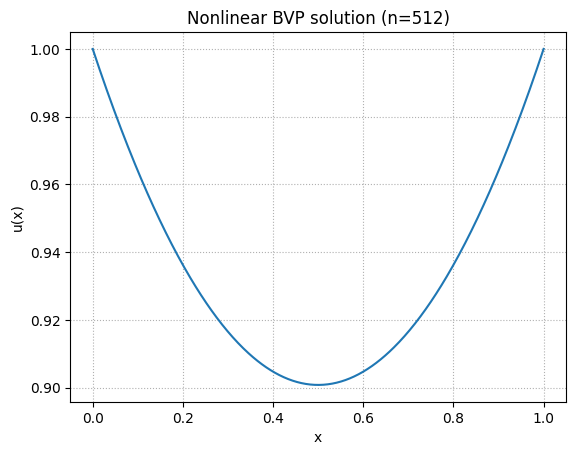

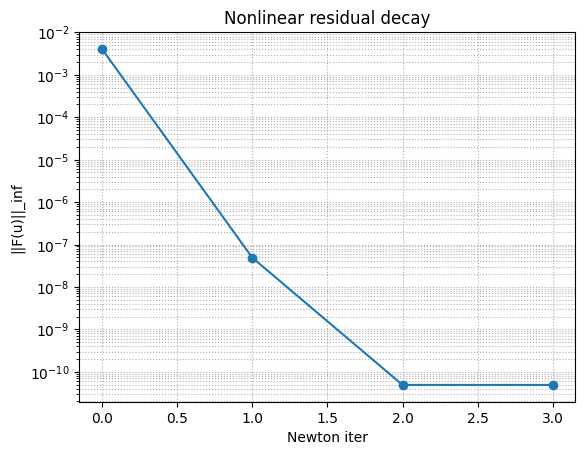

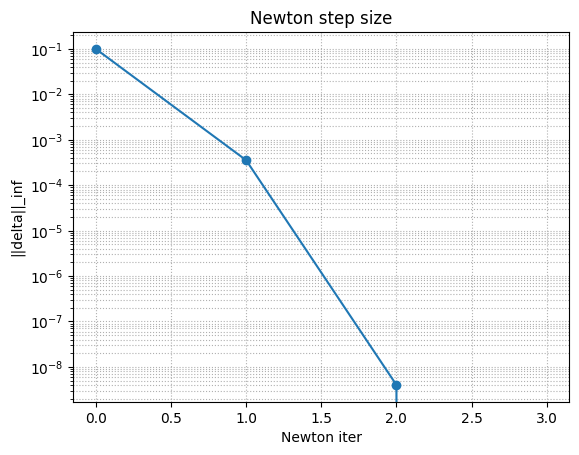

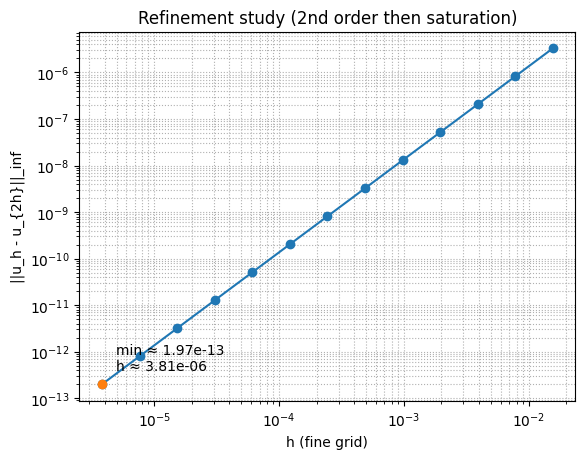

,n (fine),h,||u_h - u_{2h}||_inf,p_obs from prev,newton iters (fine)
0,64,0.015625,3.309865e-06,NaN,4
1,128,0.007812,8.273929e-07,2.000128,4
2,256,0.003906,2.068436e-07,2.000032,4
3,512,0.001953,5.171062e-08,2.000008,4
4,1024,0.000977,1.292764e-08,2.000002,4
5,2048,0.000488,3.231908e-09,2.000001,4
6,4096,0.000244,8.079770e-10,2.000000,4
7,8192,0.000122,2.019942e-10,2.000000,4
8,16384,0.000061,5.049861e-11,1.999998,4
9,32768,0.000031,1.262468e-11,1.999997,4


Last observed order p ≈ 1.999
Smallest inter-grid error ≈ 1.974e-13 at h ≈ 3.815e-06
Interpretation: 斜率≈2 的區段對應二階收斂；到達最小點後誤差不再下降（round-off 飽和）。


In [10]:
n = 512
x, u, hist = solve_nonlinear_bvp_sin(n)

plt.figure(); plt.plot(x, u); plt.grid(True, which="both", ls=":")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title(f"Nonlinear BVP solution (n={n})"); plt.show()

if hist:
    its  = [t[0] for t in hist]
    R    = [t[1] for t in hist]
    step = [t[2] for t in hist]
    lam  = [t[3] for t in hist]

    plt.figure(); plt.semilogy(its, R, marker='o')
    plt.xlabel("Newton iter"); plt.ylabel("||F(u)||_inf")
    plt.title("Nonlinear residual decay")
    plt.grid(True, which="both", ls=":"); plt.show()

    plt.figure(); plt.semilogy(its, step, marker='o')
    plt.xlabel("Newton iter"); plt.ylabel("||delta||_inf")
    plt.title("Newton step size")
    plt.grid(True, which="both", ls=":"); plt.show()


sols, recs = refinement_study_sin(levels=14, N0=32) 

hs   = [r["h"] for r in recs]
errs = [r["||u_h - u_{2h}||_inf"] for r in recs]

imin = int(np.argmin(errs))
plt.figure()
plt.loglog(hs, errs, marker='o')
plt.loglog(hs[imin], errs[imin], 'o')  # 標示 min 點
plt.annotate(f"min ≈ {errs[imin]:.2e}\nh ≈ {hs[imin]:.2e}",
             (hs[imin], errs[imin]), textcoords="offset points", xytext=(10,10))

plt.xlabel("h (fine grid)")
plt.ylabel("||u_h - u_{2h}||_inf")
plt.title("Refinement study (2nd order then saturation)")
plt.grid(True, which="both", ls=":")
plt.show()

df = pd.DataFrame(recs)
display(df)

if len(errs) >= 2 and errs[-1] > 0 and errs[-2] > 0:
    p_last = math.log(errs[-2]/errs[-1], 2.0)
else:
    p_last = None

print(f"Last observed order p ≈ {p_last:.3f}" if p_last is not None else "p_last N/A")
print(f"Smallest inter-grid error ≈ {errs[imin]:.3e} at h ≈ {hs[imin]:.3e}")
print("Interpretation: 斜率≈2 的區段對應二階收斂；到達最小點後誤差不再下降（round-off 飽和）。")
